## Прогнозирование стоимости автомобиля по характеристикам

# Описание признаков в тестовом датасете:
* bodyType - тип кузова
* brand - марка автомобиля 
* car_url - адрес страницы с объявлением 
* color - цвет автомобиля
* complectation_dict - словарь с параметрами комплектации авто
* description - описание автомобиля 
* engineDisplacement - объем двигателя
* enginePower - мощность двигателя
* equipment_dict - словарь оснащения авто 
* fuelType - тип топлива 
* image - изображение 
* mileage - пробег 
* modelDate - дата выпуска модели
* model_info - информация о модели
* model_name - название модели
* name - имя
* numberOfDoors - кол-во дверей
* parsing_unixtime - когда был произведен парсинг данных
* priceCurrency - валюта
* productionDate - год производства
* sell_id
* super_gen - словарь с дополинтельной информацией
* vehicleConfiguration - конфигурация транспортного средства
* vehicleTransmission - трансмиссия
* vendor - страна-изготовитель
* Владельцы - кол-во владельцев
* Владение - период владения
* ПТС
* Привод
* Руль
* Состояние
* Таможня

In [1]:
import numpy as np 
import pandas as pd 
import sys
import time
import datetime
import requests as r
import json
from bs4 import BeautifulSoup
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from tqdm.notebook import tqdm
from catboost import CatBoostRegressor
from sklearn.preprocessing import LabelEncoder
import pandas_profiling
import warnings
warnings.simplefilter('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import Series
from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor  
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.base import clone

In [2]:
# фиксируем RANDOM_SEED
RANDOM_SEED = 42

In [3]:
#запишем функцию для вычисления итоговой метрики
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))

# Код парсинга

In [4]:
'''START_URL='https://auto.ru/moskva/cars/used/'

pages_url_list=[]'''

"START_URL='https://auto.ru/moskva/cars/used/'\n\npages_url_list=[]"

In [5]:
'''while len(pages_url_list)<5000: 
    for i in range(1,99):   
        response = r.get( START_URL+'?page=%s'%i)
        page = BeautifulSoup(response.text, 'html.parser')
        for link in page.findAll('a',{"class": "Link OfferThumb"}):
            try:
                if link['href'] not in pages_url_list: 
                    pages_url_list.append(link['href'])
            except:
                pass
    print(len(pages_url_list))   
    time.sleep(10)'''

'while len(pages_url_list)<5000: \n    for i in range(1,99):   \n        response = r.get( START_URL+\'?page=%s\'%i)\n        page = BeautifulSoup(response.text, \'html.parser\')\n        for link in page.findAll(\'a\',{"class": "Link OfferThumb"}):\n            try:\n                if link[\'href\'] not in pages_url_list: \n                    pages_url_list.append(link[\'href\'])\n            except:\n                pass\n    print(len(pages_url_list))   \n    time.sleep(10)'

In [6]:
"""cars_list = []
for item in pages_url_list:
    response = r.get(item)
    response.encoding = 'utf8'
    page = BeautifulSoup(response.text, 'html.parser')
    if page.find('div', class_='CardSold') == None:
        try:
            json_data = json.loads(
                page.find('script', type="application/ld+json").string)
        except:
            print(item)
            pass
        cls_str = 'CardInfoRow_'
        span_str = 'CardInfoRow__cell'
        try:
            cars_list.append({
            'bodyType': json_data['bodyType'],
            'brand': json_data['brand'],
            'car_url': json_data['offers']['url'],
            'color': json_data['color'],
            'description': json_data['description'],
            'engineDisplacement': json_data['vehicleEngine']['engineDisplacement'],
            'enginePower': json_data['vehicleEngine']['enginePower'],
            'fuelType': json_data['fuelType'],
            'image': json_data['image'],
            'mileage': page.find(
                'li', class_=cls_str+'kmAge').find_all('span')[1].text,
            'modelDate': json_data['modelDate'],
            'model_name': json_data['name'],
            'name': json_data['vehicleEngine']['name'],
            'numberOfDoors': json_data['numberOfDoors'],
            'parsing_unixtime': int(time.time()),
            'priceCurrency': json_data['offers']['priceCurrency'],
            'productionDate': json_data['productionDate'],
            'sell_id': page.find(
                'div', title='Идентификатор объявления').text,
            'vehicleConfiguration': json_data['vehicleConfiguration'],
            'vehicleTransmission': json_data['vehicleTransmission'],
            'Владельцы': page.find(
                'li', class_=cls_str+'ownersCount').find_all('span')[1].text,
            'ПТС': page.find(
                'li', class_=cls_str+'pts').find_all('span')[1].text,
            'Привод': page.find(
                'li', class_=cls_str+'drive').find_all('span')[1].text,
            'Руль': page.find(
                'li', class_=cls_str+'wheel').find_all('span')[1].text,
            'Состояние': page.find(
                'li', class_=cls_str+'state').find_all('span')[1].text,
            'Таможня': page.find(
                'li', class_=cls_str+'customs').find_all('span')[1].text,
            'price': page.find(
                'span', class_='OfferPriceCaption__price').text
            })
        except:
            print(item)
            pass

   # else cars_list = []

    #print('Ожидаю 0.1 секунды...')
    time.sleep(0.1)"""

'cars_list = []\nfor item in pages_url_list:\n    response = r.get(item)\n    response.encoding = \'utf8\'\n    page = BeautifulSoup(response.text, \'html.parser\')\n    if page.find(\'div\', class_=\'CardSold\') == None:\n        try:\n            json_data = json.loads(\n                page.find(\'script\', type="application/ld+json").string)\n        except:\n            print(item)\n            pass\n        cls_str = \'CardInfoRow_\'\n        span_str = \'CardInfoRow__cell\'\n        try:\n            cars_list.append({\n            \'bodyType\': json_data[\'bodyType\'],\n            \'brand\': json_data[\'brand\'],\n            \'car_url\': json_data[\'offers\'][\'url\'],\n            \'color\': json_data[\'color\'],\n            \'description\': json_data[\'description\'],\n            \'engineDisplacement\': json_data[\'vehicleEngine\'][\'engineDisplacement\'],\n            \'enginePower\': json_data[\'vehicleEngine\'][\'enginePower\'],\n            \'fuelType\': json_data[\'f

In [7]:
"""# переводим в удобный для нас вид
df = pd.DataFrame(cars_list)
# проверяем на дубликаты, можно по двум признакам car_url или sell_id
df['sell_id'].duplicated().sum()
# сохраняем в csv
df.to_csv('cars.csv', index=False)"""

"# переводим в удобный для нас вид\ndf = pd.DataFrame(cars_list)\n# проверяем на дубликаты, можно по двум признакам car_url или sell_id\ndf['sell_id'].duplicated().sum()\n# сохраняем в csv\ndf.to_csv('cars.csv', index=False)"

# Setup

In [8]:
VERSION    = 16
DIR_TRAIN  = '../input/cars-df/' # подключил к ноутбуку внешний датасет
DIR_TEST   = '../input/sf-dst-car-price-prediction/'
VAL_SIZE   = 0.20   # 20%

# Data

In [9]:
!ls '../input'

cars-df  sf-dst-car-price-prediction


In [10]:
train = pd.read_csv(DIR_TRAIN+'cars.csv') # датасет для обучения модели
test = pd.read_csv(DIR_TEST+'test.csv')
sample_submission = pd.read_csv(DIR_TEST+'sample_submission.csv')

In [11]:
train.sample(5)

,bodyType,brand,car_url,color,description,engineDisplacement,enginePower,fuelType,image,mileage,...,productionDate,vehicleConfiguration,vehicleTransmission,Владельцы,ПТС,Привод,Руль,Состояние,Таможня,price
28478,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/superb/11...,коричневый,Один владелец\nЛюбые проверки\nПомогатары не и...,1.8 LTR,152 N12,бензин,https://autoru.naydex.net/9BLat2w73/5235e3feo_...,144437,...,2014,LIFTBACK ROBOT 1.8,роботизированная,1 владелец,Оригинал,передний,Левый,Не требует ремонта,Растаможен,950000
25261,хэтчбек 5 дв.,MITSUBISHI,https://auto.ru/cars/used/sale/mitsubishi/colt...,серый,Комфорт: 6. Элементы экстерьера: 1. Обзор: 2. ...,1.5 LTR,109 N12,бензин,https://autoru.naydex.net/1z7B7wo97/fb37f18_bX...,126000,...,2005,HATCHBACK_5_DOORS ROBOT 1.5,роботизированная,2 владельца,Оригинал,передний,Левый,Не требует ремонта,Растаможен,220000
20243,внедорожник 5 дв.,BMW,https://auto.ru/cars/used/sale/bmw/x5/10705690...,белый,Салоны и другие помощники просьба не беспокоить.,3.0 LTR,249 N12,дизель,https://avatars.mds.yandex.net/get-autoru-vos/...,65000,...,2017,ALLROAD_5_DOORS AUTOMATIC 3.0,автоматическая,2 владельца,Оригинал,полный,Левый,Не требует ремонта,Растаможен,3700000
8006,седан,VOLKSWAGEN,https://auto.ru/cars/used/sale/volkswagen/jett...,серебристый,"Продаю автомобиль ,в хорошем состоянии, технич...",1.4 LTR,122 N12,бензин,https://autoru.naydex.net/s1Es6A975/ab8c8ahfBe...,180000,...,2015,SEDAN ROBOT 1.4,роботизированная,2 владельца,Оригинал,передний,Левый,Не требует ремонта,Растаможен,780000
3748,внедорожник 5 дв.,LAND_ROVER,https://auto.ru/cars/used/sale/land_rover/rang...,чёрный,Комфорт: 20. Салон: 18. Безопасность: 8. Обзор...,5.0 LTR,510 N12,бензин,https://avatars.mds.yandex.net/get-autoru-vos/...,147 000 км,...,2014,ALLROAD_5_DOORS AUTOMATIC 5.0,автоматическая,1 владелец,Оригинал,полный,Левый,Не требует ремонта,Растаможен,2 750 000 ₽


In [12]:
train.info()
train.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33529 entries, 0 to 33528
Data columns (total 25 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   bodyType              33529 non-null  object
 1   brand                 33529 non-null  object
 2   car_url               33529 non-null  object
 3   color                 33529 non-null  object
 4   description           33529 non-null  object
 5   engineDisplacement    33529 non-null  object
 6   enginePower           33529 non-null  object
 7   fuelType              33529 non-null  object
 8   image                 33529 non-null  object
 9   mileage               33529 non-null  object
 10  modelDate             33529 non-null  int64 
 11  model_name            33529 non-null  object
 12  name                  33529 non-null  object
 13  numberOfDoors         33529 non-null  int64 
 14  priceCurrency         33529 non-null  object
 15  productionDate        33529 non-null

bodyType                0
brand                   0
car_url                 0
color                   0
description             0
engineDisplacement      0
enginePower             0
fuelType                0
image                   0
mileage                 0
modelDate               0
model_name              0
name                    0
numberOfDoors           0
priceCurrency           0
productionDate          0
vehicleConfiguration    0
vehicleTransmission     0
Владельцы               0
ПТС                     0
Привод                  0
Руль                    0
Состояние               0
Таможня                 0
price                   0
dtype: int64

In [13]:
test.sample(5)

,bodyType,brand,car_url,color,complectation_dict,description,engineDisplacement,enginePower,equipment_dict,fuelType,...,vehicleConfiguration,vehicleTransmission,vendor,Владельцы,Владение,ПТС,Привод,Руль,Состояние,Таможня
17371,купе-хардтоп,MERCEDES,https://auto.ru/cars/used/sale/mercedes/e_klas...,белый,NaN,"Купил автомобиль в начале августа, весь обслуж...",1.8 LTR,184 N12,"{""cruise-control"":true,""alloy-wheel-disks"":tru...",бензин,...,COUPE_HARDTOP AUTOMATIC 1.8,автоматическая,EUROPEAN,2 владельца,NaN,Оригинал,задний,Левый,Не требует ремонта,Растаможен
11697,внедорожник 5 дв.,NISSAN,https://auto.ru/cars/used/sale/nissan/x_trail/...,зелёный,NaN,Преимущества этого автомобиля:\n\n*ПРОИЗВЕДЕНА...,2.0 LTR,144 N12,"{""cruise-control"":true,""engine-proof"":true,""as...",бензин,...,ALLROAD_5_DOORS VARIATOR 2.0,вариатор,JAPANESE,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
1809,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/rapid/109...,коричневый,"{""id"":""21032385"",""name"":""Style"",""available_opt...","Автомобиль куплен у официального дилера ""Шкода...",1.4 LTR,125 N12,"{""engine-proof"":true,""cruise-control"":true,""es...",бензин,...,LIFTBACK ROBOT 1.4,роботизированная,EUROPEAN,1 владелец,1 год и 3 месяца,Оригинал,передний,Левый,Не требует ремонта,Растаможен
11086,седан,NISSAN,https://auto.ru/cars/used/sale/nissan/almera_c...,серебристый,NaN,ЛОТ: 01206639\nFAVORIT MOTORS KIA Север\n\nВы ...,1.6 LTR,107 N12,"{""alloy-wheel-disks"":true,""tinted-glass"":true,...",бензин,...,SEDAN MECHANICAL 1.6,механическая,JAPANESE,2 владельца,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
25902,хэтчбек 5 дв.,VOLKSWAGEN,https://auto.ru/cars/used/sale/volkswagen/golf...,красный,NaN,Машина только для фанатов! \nМексиканский тушк...,1.8 LTR,90 N12,"{""tinted-glass"":true,""steel-wheels"":true,""ptf""...",бензин,...,HATCHBACK_5_DOORS MECHANICAL 1.8,механическая,EUROPEAN,3 или более,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен


In [14]:
test.info()
test.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34686 entries, 0 to 34685
Data columns (total 32 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   bodyType              34686 non-null  object
 1   brand                 34686 non-null  object
 2   car_url               34686 non-null  object
 3   color                 34686 non-null  object
 4   complectation_dict    6418 non-null   object
 5   description           34686 non-null  object
 6   engineDisplacement    34686 non-null  object
 7   enginePower           34686 non-null  object
 8   equipment_dict        24690 non-null  object
 9   fuelType              34686 non-null  object
 10  image                 34686 non-null  object
 11  mileage               34686 non-null  int64 
 12  modelDate             34686 non-null  int64 
 13  model_info            34686 non-null  object
 14  model_name            34686 non-null  object
 15  name                  34686 non-null

bodyType                    0
brand                       0
car_url                     0
color                       0
complectation_dict      28268
description                 0
engineDisplacement          0
enginePower                 0
equipment_dict           9996
fuelType                    0
image                       0
mileage                     0
modelDate                   0
model_info                  0
model_name                  0
name                        0
numberOfDoors               0
parsing_unixtime            0
priceCurrency               0
productionDate              0
sell_id                     0
super_gen                   0
vehicleConfiguration        0
vehicleTransmission         0
vendor                      0
Владельцы                   0
Владение                22691
ПТС                         1
Привод                      0
Руль                        0
Состояние                   0
Таможня                     0
dtype: int64

In [15]:
pd.set_option('display.max_columns', None)
print('Размерность тренировочного датасета: ', train.shape)
display(train.head(5))
print('Размерность тестового датасета: ', test.shape)
display(test.head(5))

Размерность тренировочного датасета:  (33529, 25)


,bodyType,brand,car_url,color,description,engineDisplacement,enginePower,fuelType,image,mileage,modelDate,model_name,name,numberOfDoors,priceCurrency,productionDate,vehicleConfiguration,vehicleTransmission,Владельцы,ПТС,Привод,Руль,Состояние,Таможня,price
0,седан,MERCEDES,https://auto.ru/cars/used/sale/mercedes/e_klas...,чёрный,Автомобиль в который вложена Душа не требует о...,3.2 LTR,220 N12,бензин,https://avatars.mds.yandex.net/get-autoru-vos/...,240 000 км,1992,Mercedes-Benz E-Класс I (W124) 320,3.2 AT,4,RUB,1994,SEDAN AUTOMATIC 3.2,автоматическая,3 или более,Оригинал,задний,Левый,Не требует ремонта,Растаможен,3 000 000 ₽
1,хэтчбек 5 дв.,CHEVROLET,https://auto.ru/cars/used/sale/chevrolet/aveo/...,белый,Я СОБСТВЕННИК!!! НЕ ПЕРЕКУП\nМашина в основном...,1.6 LTR,115 N12,бензин,https://avatars.mds.yandex.net/get-autoru-vos/...,53 800 км,2011,Chevrolet Aveo II,1.6 AT,5,RUB,2013,HATCHBACK_5_DOORS AUTOMATIC 1.6,автоматическая,3 или более,Оригинал,передний,Левый,Не требует ремонта,Растаможен,638 000 ₽
2,внедорожник 5 дв.,LAMBORGHINI,https://auto.ru/cars/used/sale/lamborghini/uru...,жёлтый,Год выпуска: 2019. Пробег: 40 100 км. Кузов: в...,4.0 LTR,650 N12,бензин,https://autoru.naydex.net/dVb17C804/f1af98yqCU...,40 100 км,2017,Lamborghini Urus I,4.0 AT,5,RUB,2019,ALLROAD_5_DOORS AUTOMATIC 4.0,автоматическая,1 владелец,Оригинал,полный,Левый,Не требует ремонта,Растаможен,22 000 000 ₽
3,седан,BMW,https://auto.ru/cars/used/sale/bmw/m3/11034070...,синий,"M3 2016 Рестайлинг,Individual в цвете tanzanit...",3.0 LTR,431 N12,бензин,https://autoru.naydex.net/dVb17C804/f1af98yqCU...,50 000 км,2014,BMW M3 V (F80),3.0 AMT,4,RUB,2016,SEDAN ROBOT 3.0,роботизированная,2 владельца,Оригинал,задний,Левый,Не требует ремонта,Растаможен,4 740 000 ₽
4,купе,MCLAREN,https://auto.ru/cars/used/sale/mclaren/720s/11...,чёрный,"В продаже McLaren 720S Perfomance, в идеальном...",4.0 LTR,720 N12,бензин,https://avatars.mds.yandex.net/get-autoru-vos/...,4 500 км,2017,McLaren 720S,4.0 AMT,2,RUB,2018,COUPE ROBOT 4.0,роботизированная,1 владелец,Оригинал,задний,Левый,Не требует ремонта,Растаможен,22 500 000 ₽


Размерность тестового датасета:  (34686, 32)


,bodyType,brand,car_url,color,complectation_dict,description,engineDisplacement,enginePower,equipment_dict,fuelType,image,mileage,modelDate,model_info,model_name,name,numberOfDoors,parsing_unixtime,priceCurrency,productionDate,sell_id,super_gen,vehicleConfiguration,vehicleTransmission,vendor,Владельцы,Владение,ПТС,Привод,Руль,Состояние,Таможня
0,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,синий,NaN,"Все автомобили, представленные в продаже, прох...",1.2 LTR,105 N12,"{""engine-proof"":true,""tinted-glass"":true,""airb...",бензин,https://autoru.naydex.net/o9DBXQ270/5ac010hAY0...,74000,2013,"{""code"":""OCTAVIA"",""name"":""Octavia"",""ru_name"":""...",OCTAVIA,1.2 AMT (105 л.с.),5,1603226273,RUB,2014,1100575026,"{""id"":""10373605"",""displacement"":1197,""engine_t...",LIFTBACK ROBOT 1.2,роботизированная,EUROPEAN,3 или более,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
1,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,чёрный,NaN,ЛОТ: 01217195\nАвтопрага Север\nДанный автомоб...,1.6 LTR,110 N12,"{""cruise-control"":true,""asr"":true,""esp"":true,""...",бензин,https://autoru.naydex.net/o9DBXQ270/5ac010hAY0...,60563,2017,"{""code"":""OCTAVIA"",""name"":""Octavia"",""ru_name"":""...",OCTAVIA,1.6 MT (110 л.с.),5,1603226277,RUB,2017,1100549428,"{""id"":""20913311"",""displacement"":1598,""engine_t...",LIFTBACK MECHANICAL 1.6,механическая,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
2,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/superb/11...,серый,"{""id"":""20026336"",""name"":""Ambition"",""available_...","Все автомобили, представленные в продаже, прох...",1.8 LTR,152 N12,"{""cruise-control"":true,""tinted-glass"":true,""es...",бензин,https://avatars.mds.yandex.net/get-autoru-vos/...,88000,2013,"{""code"":""SUPERB"",""name"":""Superb"",""ru_name"":""Су...",SUPERB,DSG 1.8 AMT (152 л.с.),5,1603226280,RUB,2014,1100658222,"{""id"":""20026323"",""nameplate"":""DSG"",""displaceme...",LIFTBACK ROBOT 1.8,роботизированная,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
3,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,коричневый,"{""id"":""20803582"",""name"":""Ambition"",""available_...",КОМПЛЕКТ ЗИМНЕЙ (ЛЕТНЕЙ) РЕЗИНЫ ПО СЕЗОНУ В ПО...,1.6 LTR,110 N12,"{""cruise-control"":true,""roller-blind-for-rear-...",бензин,https://autoru.naydex.net/o9DBXQ270/5ac010hAY0...,95000,2013,"{""code"":""OCTAVIA"",""name"":""Octavia"",""ru_name"":""...",OCTAVIA,1.6 AT (110 л.с.),5,1603226284,RUB,2014,1100937408,"{""id"":""20105521"",""displacement"":1598,""engine_t...",LIFTBACK AUTOMATIC 1.6,автоматическая,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
4,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,белый,NaN,ЛОТ: 01220889\nАвтопрага Север\n\nВы можете по...,1.8 LTR,152 N12,"{""cruise-control"":true,""asr"":true,""esp"":true,""...",бензин,https://autoru.naydex.net/o9DBXQ270/5ac010hAY0...,58536,2008,"{""code"":""OCTAVIA"",""name"":""Octavia"",""ru_name"":""...",OCTAVIA,1.8 AT (152 л.с.),5,1603226288,RUB,2012,1101037972,"{""id"":""4561004"",""displacement"":1798,""engine_ty...",LIFTBACK AUTOMATIC 1.8,автоматическая,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен


## Data Preprocessing

### удаляем дубликаты

In [16]:
train = train.drop_duplicates(subset=['car_url'])

### проверим датасеты на дубликаты по уникальному идентификатору объявления

In [17]:
train['car_url'].duplicated().sum()
test['sell_id'].duplicated().sum()

0

### удалим из тестового датафрейма данные, которые не удалось спарсить в тренировочный датасет

In [18]:
test.drop(['complectation_dict', 'equipment_dict', 'model_info',
           'super_gen', 'vendor', 'Владение'], axis=1, inplace=True)

In [19]:
test['price'] = 0
df_train = train
df_test = test

# удалим строки, где отсутствует цена
df_train = df_train.dropna(axis=0, subset=['price'])

# объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

In [20]:
data.sample(5)

,bodyType,brand,car_url,color,description,engineDisplacement,enginePower,fuelType,image,mileage,modelDate,model_name,name,numberOfDoors,parsing_unixtime,priceCurrency,productionDate,sell_id,vehicleConfiguration,vehicleTransmission,Владельцы,ПТС,Привод,Руль,Состояние,Таможня,price,sample
47590,хэтчбек 5 дв.,NISSAN,https://auto.ru/cars/used/sale/nissan/note/110...,синий,Состояние хорошее. Комплект новых летних колес...,1.6 LTR,110 N12,бензин,https://autoru.naydex.net/ljqD86H23/16705aqI2/...,270000,2008,NOTE,Nissan Note I,5,NaN,RUB,2008,NaN,HATCHBACK_5_DOORS AUTOMATIC 1.6,автоматическая,3 или более,Оригинал,передний,Левый,Не требует ремонта,Растаможен,420000,1
34821,седан,VOLKSWAGEN,https://auto.ru/cars/used/sale/volkswagen/jett...,белый,Комплектация:\n• Антиблокировочная система\n• ...,1.4 LTR,150 N12,бензин,https://avatars.mds.yandex.net/get-autoru-vos/...,9 407 км,2018,Volkswagen Jetta VII,1.4 AT,4,NaN,RUB,2019,NaN,SEDAN AUTOMATIC 1.4,автоматическая,1 владелец,Оригинал,передний,Левый,Не требует ремонта,Растаможен,1 900 000 ₽,1
5774,седан,HONDA,https://auto.ru/cars/used/sale/honda/civic/110...,золотистый,"Добрейшего дня ! Продатся сей авто , долго слу...",1.8 LTR,140 N12,бензин,https://avatars.mds.yandex.net/get-autoru-vos/...,210000,2005,CIVIC,1.8 MT (140 л.с.),4,1.603256e+09,RUB,2008,1.101138e+09,SEDAN MECHANICAL 1.8,механическая,3 или более,Оригинал,передний,Левый,Не требует ремонта,Растаможен,0,0
31595,хэтчбек 5 дв.,MERCEDES,https://auto.ru/cars/used/sale/mercedes/a_klas...,белый,"Машина в отличном техническом состоянии, сиден...",1.6 LTR,122 N12,бензин,https://avatars.mds.yandex.net/get-autoru-vos/...,80000,2012,A_KLASSE,180 1.6 AMT (122 л.с.),5,1.603588e+09,RUB,2015,1.101360e+09,HATCHBACK_5_DOORS ROBOT 1.6,роботизированная,2 владельца,Оригинал,передний,Левый,Не требует ремонта,Растаможен,0,0
26956,седан,MITSUBISHI,https://auto.ru/cars/used/sale/mitsubishi/lanc...,серый,MITSUBISHI LANCER 1.6 2005 в отличном состояни...,1.6 LTR,98 N12,бензин,https://avatars.mds.yandex.net/get-autoru-vos/...,390000,2000,LANCER,1.6 MT (98 л.с.),4,1.603261e+09,RUB,2005,1.101309e+09,SEDAN MECHANICAL 1.6,механическая,3 или более,Оригинал,передний,Левый,Не требует ремонта,Растаможен,0,0


### еще раз проверим на дубликаты

In [21]:
data['car_url'].value_counts()
data = data.drop_duplicates(subset=['car_url'])

In [22]:
data

,bodyType,brand,car_url,color,description,engineDisplacement,enginePower,fuelType,image,mileage,modelDate,model_name,name,numberOfDoors,parsing_unixtime,priceCurrency,productionDate,sell_id,vehicleConfiguration,vehicleTransmission,Владельцы,ПТС,Привод,Руль,Состояние,Таможня,price,sample
0,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,синий,"Все автомобили, представленные в продаже, прох...",1.2 LTR,105 N12,бензин,https://autoru.naydex.net/o9DBXQ270/5ac010hAY0...,74000,2013,OCTAVIA,1.2 AMT (105 л.с.),5,1.603226e+09,RUB,2014,1.100575e+09,LIFTBACK ROBOT 1.2,роботизированная,3 или более,Оригинал,передний,Левый,Не требует ремонта,Растаможен,0,0
1,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,чёрный,ЛОТ: 01217195\nАвтопрага Север\nДанный автомоб...,1.6 LTR,110 N12,бензин,https://autoru.naydex.net/o9DBXQ270/5ac010hAY0...,60563,2017,OCTAVIA,1.6 MT (110 л.с.),5,1.603226e+09,RUB,2017,1.100549e+09,LIFTBACK MECHANICAL 1.6,механическая,1 владелец,Оригинал,передний,Левый,Не требует ремонта,Растаможен,0,0
2,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/superb/11...,серый,"Все автомобили, представленные в продаже, прох...",1.8 LTR,152 N12,бензин,https://avatars.mds.yandex.net/get-autoru-vos/...,88000,2013,SUPERB,DSG 1.8 AMT (152 л.с.),5,1.603226e+09,RUB,2014,1.100658e+09,LIFTBACK ROBOT 1.8,роботизированная,1 владелец,Оригинал,передний,Левый,Не требует ремонта,Растаможен,0,0
3,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,коричневый,КОМПЛЕКТ ЗИМНЕЙ (ЛЕТНЕЙ) РЕЗИНЫ ПО СЕЗОНУ В ПО...,1.6 LTR,110 N12,бензин,https://autoru.naydex.net/o9DBXQ270/5ac010hAY0...,95000,2013,OCTAVIA,1.6 AT (110 л.с.),5,1.603226e+09,RUB,2014,1.100937e+09,LIFTBACK AUTOMATIC 1.6,автоматическая,1 владелец,Оригинал,передний,Левый,Не требует ремонта,Растаможен,0,0
4,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,белый,ЛОТ: 01220889\nАвтопрага Север\n\nВы можете по...,1.8 LTR,152 N12,бензин,https://autoru.naydex.net/o9DBXQ270/5ac010hAY0...,58536,2008,OCTAVIA,1.8 AT (152 л.с.),5,1.603226e+09,RUB,2012,1.101038e+09,LIFTBACK AUTOMATIC 1.8,автоматическая,1 владелец,Оригинал,передний,Левый,Не требует ремонта,Растаможен,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68210,хэтчбек 5 дв.,HONDA,https://auto.ru/cars/used/sale/honda/civic/110...,красный,"Машина в отличном состоянии, есть что передела...",1.5 LTR,115 N12,бензин,https://autoru.naydex.net/VyLm91f05/4c3ef9yM_4...,373317,1999,CIVIC,Honda Civic VI,5,NaN,RUB,1999,NaN,HATCHBACK_5_DOORS MECHANICAL 1.5,механическая,3 или более,Дубликат,передний,Левый,Не требует ремонта,Растаможен,210000,1
68211,компактвэн,HONDA,https://auto.ru/cars/used/sale/honda/stream/11...,серебристый,Продам свою ласточку или поменяю на более деше...,1.7 LTR,130 N12,бензин,https://avatars.mds.yandex.net/get-autoru-vos/...,311000,2002,STREAM,Honda Stream I,5,NaN,RUB,2002,NaN,COMPACTVAN AUTOMATIC 1.7,автоматическая,3 или более,Оригинал,передний,Правый,Не требует ремонта,Растаможен,330000,1
68212,седан,HONDA,https://auto.ru/cars/used/sale/honda/civic/110...,серый,"Продаю личный автомобиль. Технически исправен,...",1.8 LTR,140 N12,бензин,https://avatars.mds.yandex.net/get-autoru-vos/...,196000,2008,CIVIC,Honda Civic VIII Рестайлинг,4,NaN,RUB,2008,NaN,SEDAN MECHANICAL 1.8,механическая,3 или более,Дубликат,передний,Левый,Не требует ремонта,Растаможен,430000,1
68213,хэтчбек 5 дв.,HONDA,https://auto.ru/cars/used/sale/honda/civic/110...,синий,"В нормальном состоянии, требует внимание кузов...",1.4 LTR,90 N12,бензин,https://autoru.naydex.net/VyLm91f05/4c3ef9yM_4...,350000,2000,CIVIC,Honda Civic VI,5,NaN,RUB,2000,NaN,HATCHBACK_5_DOORS MECHANICAL 1.4,механическая,3 или более,Дубликат,передний,Левый,Не требует ремонта,Растаможен,135000,1


In [23]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 65607 entries, 0 to 68214
Data columns (total 28 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bodyType              65607 non-null  object 
 1   brand                 65607 non-null  object 
 2   car_url               65607 non-null  object 
 3   color                 65607 non-null  object 
 4   description           65607 non-null  object 
 5   engineDisplacement    65607 non-null  object 
 6   enginePower           65607 non-null  object 
 7   fuelType              65607 non-null  object 
 8   image                 65607 non-null  object 
 9   mileage               65607 non-null  object 
 10  modelDate             65607 non-null  int64  
 11  model_name            65607 non-null  object 
 12  name                  65607 non-null  object 
 13  numberOfDoors         65607 non-null  int64  
 14  parsing_unixtime      34686 non-null  float64
 15  priceCurrency      

In [24]:
data.isna().sum()

bodyType                    0
brand                       0
car_url                     0
color                       0
description                 0
engineDisplacement          0
enginePower                 0
fuelType                    0
image                       0
mileage                     0
modelDate                   0
model_name                  0
name                        0
numberOfDoors               0
parsing_unixtime        30921
priceCurrency               0
productionDate              0
sell_id                 30921
vehicleConfiguration        0
vehicleTransmission         0
Владельцы                   0
ПТС                         1
Привод                      0
Руль                        0
Состояние                   0
Таможня                     0
price                       0
sample                      0
dtype: int64

Краткий итог: в тренировочной выборке 33531 объявлений, в тестовой - 34686. Всего данных после удаления дубликатов - 65609 объявлений. Имеется 28 признаков. Из числовых признаков у нас: modelDate, numberOfDoors, productionDate,parsing_unixtime. Остальные - типа Object. Пропуски в признаках price,parsing_unixtime,sell_id появились исскуственно. Также добавился признак sample для обозначения принадлежности данных и последующего разделения.

# Рассмотрим каждый признак

In [25]:
#числовые:
num_cols = []

# бинарные, количество уникальных значений которых равно двум
bin_cols = []

# категориальные
cat_cols = []

**bodyType**

In [26]:
data.bodyType.value_counts()

внедорожник 5 дв.          24589
седан                      23849
хэтчбек 5 дв.               4214
лифтбек                     4159
универсал 5 дв.             2319
минивэн                     1710
купе                        1499
компактвэн                   900
хэтчбек 3 дв.                828
пикап двойная кабина         482
купе-хардтоп                 285
внедорожник 3 дв.            203
фургон                       195
родстер                      166
кабриолет                    126
седан-хардтоп                 29
микровэн                      16
пикап одинарная кабина         9
пикап полуторная кабина        7
лимузин                        6
седан 2 дв.                    6
внедорожник открытый           4
тарга                          2
фастбек                        2
хэтчбек 4 дв.                  1
универсал 3 дв.                1
Name: bodyType, dtype: int64

In [27]:
data['bodyType'] = data['bodyType'].astype(str).apply(lambda x: None if x.strip()=='' else x)
data['bodyType'] = data.bodyType.apply(lambda x: x.split(' ')[0].lower())

In [28]:
data.bodyType.value_counts()

внедорожник      24796
седан            23855
хэтчбек           5043
лифтбек           4159
универсал         2320
минивэн           1710
купе              1499
компактвэн         900
пикап              498
купе-хардтоп       285
фургон             195
родстер            166
кабриолет          126
седан-хардтоп       29
микровэн            16
лимузин              6
фастбек              2
тарга                2
Name: bodyType, dtype: int64

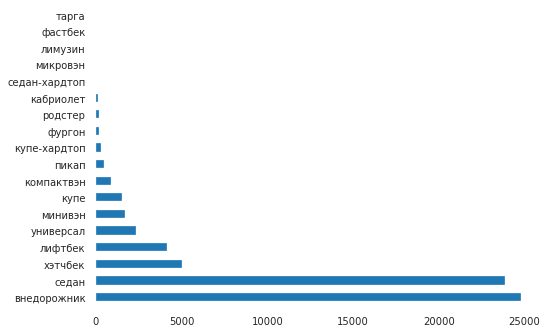

In [29]:
#посмотрим на распределение
data.bodyType.value_counts().plot.barh() 

In [30]:
cat_cols.append('bodyType')

**brand**

In [31]:
data.brand.value_counts()

BMW           8137
VOLKSWAGEN    8106
NISSAN        7793
MERCEDES      7781
TOYOTA        7445
              ... 
DATSUN           1
TATRA            1
SATURN           1
MCLAREN          1
DAIHATSU         1
Name: brand, Length: 70, dtype: int64

In [32]:
cat_cols.append('brand')

**color**

In [33]:
data.color.value_counts()

чёрный         20414
белый          12474
серый           8121
серебристый     6977
синий           6170
коричневый      3012
красный         2928
зелёный         1605
бежевый         1205
голубой          830
золотистый       448
пурпурный        443
фиолетовый       362
жёлтый           341
оранжевый        259
розовый           18
Name: color, dtype: int64

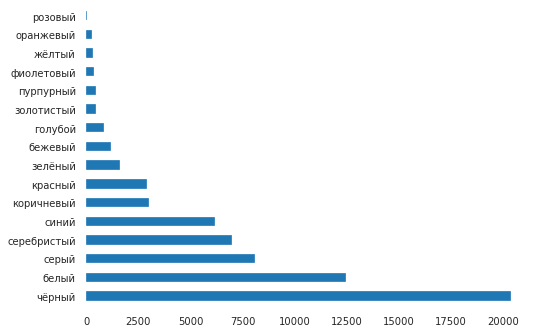

In [34]:
data.color.value_counts().plot.barh() 

In [35]:
cat_cols.append('color')

**Description**

In [36]:
# description - описание, комментарий продавца
# сгенерируем из него новый числовой признак
data['description_len'] = data.description.apply(lambda x: len(str(x)))

In [37]:
data = data.drop('description',axis=1)

In [38]:
num_cols.append('description_len')

**fuelType**

In [39]:
data.fuelType.value_counts()

бензин     53451
дизель     11599
гибрид       407
электро      137
газ           13
Name: fuelType, dtype: int64

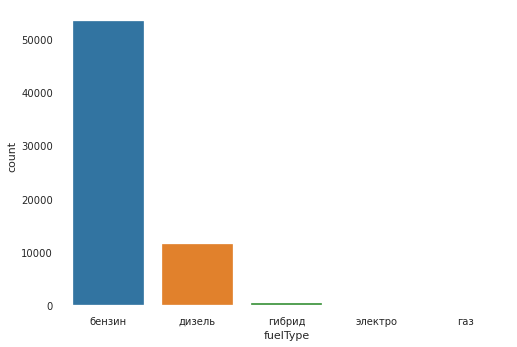

In [40]:
sns.countplot(x = 'fuelType', data = data)

In [41]:
cat_cols.append('fuelType')

**image**

In [42]:
# проверим фото на уникальность
count_photos = data.image.value_counts()
display(count_photos.head(5))

https://avatars.mds.yandex.net/get-verba/216201/2a000001609d0005e0912c12a896bbda4ab1/wizardv3mr     20
https://avatars.mds.yandex.net/get-verba/216201/2a000001609bda17487cc63d8b957ab4aab2/wizardv3mr     13
https://avatars.mds.yandex.net/get-verba/216201/2a0000016098487a9e1ff58d5ae35f3de345/wizardv3mr     13
https://avatars.mds.yandex.net/get-verba/1030388/2a000001609cf6746b94cf8334836265daaf/wizardv3mr    13
https://avatars.mds.yandex.net/get-verba/216201/2a0000016099a4e6be992d7b50134fd908fd/wizardv3mr     12
Name: image, dtype: int64

In [43]:
#получим уникальные фотографии
display(count_photos.sort_values().head(5))

https://avatars.mds.yandex.net/get-autoru-vos/2105933/c53f6f3a829053d2a019b58c6621a737/320x240                                                                                                                                   1
https://autoru.naydex.net/mcQh17801/f1b5751dCi/ZpAxhySp-6XA9ZRjLXnaIoWog-BkhRn4qCmMkbY1cVFQTXjgtBoYX89n68dzfk-xCWl6ihFdu94amzqBZYWR4HeFas5o_b3z16yEdjQl2mKatdqhM9JRrvR4yOGOEUQ-bndexoEme0jVYKvbMD0m2xoLPYtIWrrAE-YChibU1w#DSD    1
https://autoru.naydex.net/f1bm7A798/f15c727Yw/knLZg35w_7UoI2B4ogrPH2gY6Qzk0LsVusSEINBiBG_NcSbnCNoRPQfoW3aE0WjLNcbIkNd8VT9J0-dhiVLfMM9jxbsKLaf1JHY8KPZ7nk8xOdkR4Y3mNOO1wTEQgpS6cYnOf5AO4LFbgEZ2-fxdcpmjkSmuJIByMQ9OvGHfUuQ#DSD    1
https://avatars.mds.yandex.net/get-autoru-vos/1960172/45275a3fb6104c121daf156a46f1cbe4/320x240                                                                                                                                   1
https://autoru.naydex.net/dPnj9f451/637517zlM/lHxUXtSAuj1ap7X2Nv2Uf1Grlg9098iYkDmAXVDZ_IW_Z8

In [44]:
# сделаем из него бинарный признак по типу уникальности фото
data['real_photo'] = data.image.apply(lambda x: x.find('get-verba') == -1)

real = data[data['real_photo'] == False].image.value_counts()
display(real.sort_values().head(5))

https://avatars.mds.yandex.net/get-verba/216201/2a000001609d5dd359217b2561c62602c922/wizardv3mr     1
https://avatars.mds.yandex.net/get-verba/937147/2a000001609d2cd67fe5b49adc4ee8a5f619/wizardv3mr     1
https://avatars.mds.yandex.net/get-verba/1030388/2a000001609d016f8d56a7d045d692bf50d0/wizardv3mr    1
https://avatars.mds.yandex.net/get-verba/787013/2a000001609d47e6e112bcfda4d0864eeaa0/wizardv3mr     1
https://avatars.mds.yandex.net/get-verba/1030388/2a000001609160fa1a19f14ad403c6538b49/wizardv3mr    1
Name: image, dtype: int64

In [45]:
data = data.drop('image',axis=1)

In [46]:
data['real_photo'].value_counts()

True     65044
False      563
Name: real_photo, dtype: int64

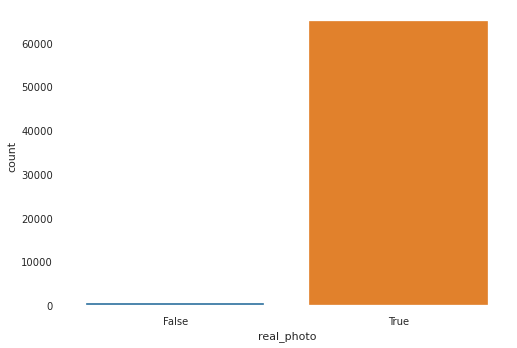

In [47]:
sns.countplot(x = 'real_photo', data = data)

In [48]:
bin_cols.append('real_photo')

**engineDisplacement**

In [49]:
data.engineDisplacement.value_counts()

2.0 LTR    14515
1.6 LTR     9973
3.0 LTR     7514
1.8 LTR     5805
2.5 LTR     4606
           ...  
6.4 LTR        2
6.5 LTR        1
0.6 LTR        1
3.9 LTR        1
0.9 LTR        1
Name: engineDisplacement, Length: 61, dtype: int64

In [50]:
#оставим только численное значение 
data.engineDisplacement = data.engineDisplacement.apply(lambda x: x[:3])
data.engineDisplacement = data.engineDisplacement.replace(' LT', '2.0')
data.engineDisplacement = data.engineDisplacement.apply(lambda x: float(x))

In [51]:
#разобьем по категориям
data["engineDisplacement"] = data["engineDisplacement"].astype('float').apply(lambda x: 4 if x >= 4 else 
   3 if x >= 3 else(2 if x >= 2 else (1 if x >= 1 else 0)))
data.engineDisplacement.value_counts()

2    25240
1    22561
3    12254
4     5463
0       89
Name: engineDisplacement, dtype: int64

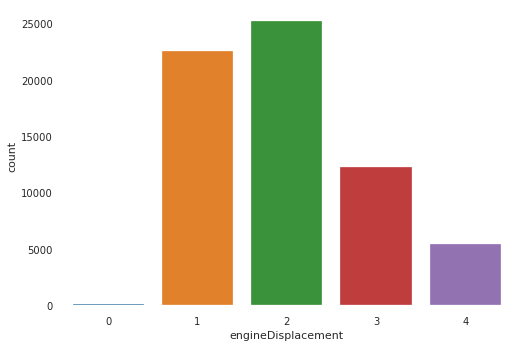

In [52]:
sns.countplot(x = 'engineDisplacement', data = data)

In [53]:
cat_cols.append('engineDisplacement')

**enginePower**

In [54]:
data.enginePower.value_counts()

150 N12    3729
249 N12    3711
110 N12    2024
184 N12    1912
170 N12    1823
           ... 
626 N12       1
30 N12        1
254 N12       1
620 N12       1
316 N12       1
Name: enginePower, Length: 362, dtype: int64

In [55]:
#преобразуем данные
data['enginePower'] = data['enginePower'].apply(lambda x: x[:3])
data['enginePower'] = data['enginePower'].replace('7 N','7')
data['enginePower'] = data['enginePower'].apply(lambda x: int(x))

<bound method Axes.barh of <matplotlib.axes._subplots.AxesSubplot object at 0x7f0b15575510>>

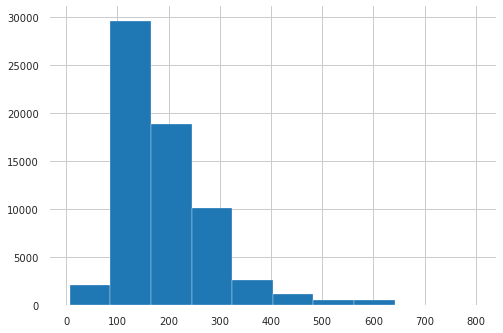

In [56]:
data.enginePower.hist().barh

In [57]:
num_cols.append('enginePower')

**mileage**

In [58]:
data['mileage'].value_counts()

200000    448
300000    392
150000    389
250000    364
180000    353
         ... 
339369      1
238791      1
29396       1
123392      1
85923       1
Name: mileage, Length: 25628, dtype: int64

In [59]:
#Очистка
data['mileage'] = data['mileage'].apply(lambda x: str(x).replace('\xa0км', ''))

In [60]:
data['mileage'] = data.mileage.apply(
    lambda x: int("".join(filter(str.isdigit, x))))

count      65607.000000
mean      152730.732986
std        98234.128988
min            1.000000
25%        82443.000000
50%       140000.000000
75%       202592.500000
max      1000000.000000
Name: mileage, dtype: float64

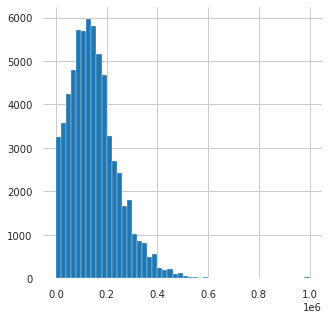

In [61]:
data['mileage'].hist(figsize=(5,5), bins=50)
data.mileage.describe()

In [62]:
#Создадим признак 'mileage_cat'  
data["mileage_cat"] = data["mileage"].apply(lambda x: 4 if x>=40000 else(3 if x>=30000 else(2 if x>=20000 else (1 if x>=10000 else 0))))

In [63]:
data.mileage_cat.value_counts()

4    58894
3     1845
2     1699
1     1595
0     1574
Name: mileage_cat, dtype: int64

In [64]:
num_cols.append('mileage')
cat_cols.append('mileage_cat')

**productionDate и modelDate**

In [65]:
data.productionDate.value_counts()

2012    5382
2013    4933
2011    4772
2014    4467
2008    4410
        ... 
1962       1
1961       1
1957       1
1948       1
1949       1
Name: productionDate, Length: 74, dtype: int64

AxesSubplot(0.125,0.125;0.775x0.755)


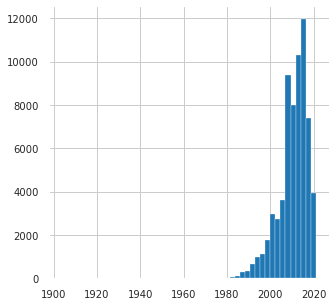

In [66]:
print(data['productionDate'].hist(figsize=(5,5), bins=50))

In [67]:
data.modelDate.value_counts()

2013    4646
2012    4616
2011    4340
2014    4191
2010    4056
        ... 
1904       1
1965       1
1946       1
1952       1
1950       1
Name: modelDate, Length: 73, dtype: int64

AxesSubplot(0.125,0.125;0.775x0.755)


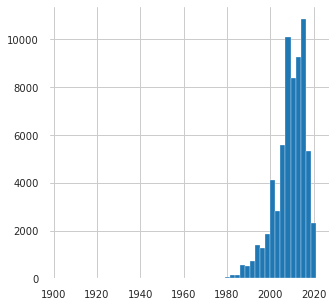

In [68]:
print(data['modelDate'].hist(figsize=(5,5), bins=50))

In [69]:
#создадим новые признаки на основе существующих: количество лет производства и возраст модели
data['prod_age'] = 2021 - data.productionDate
data['model_age'] = 2021 - data.modelDate

In [70]:
#определим эти признаки в числовые данные
num_cols.append('productionDate')
num_cols.append('modelDate')
num_cols.append('prod_age')
num_cols.append('model_age')

**model_name**

In [71]:
data.model_name.unique()

array(['OCTAVIA', 'SUPERB', 'OCTAVIA_RS', ..., 'VAMOS', 'CAPA', 'MDX'],
      dtype=object)

In [72]:
cat_cols.append('model_name')

**numberOfDoors**

In [73]:
data.numberOfDoors.value_counts() 

5    36864
4    25512
2     2129
3     1101
0        1
Name: numberOfDoors, dtype: int64

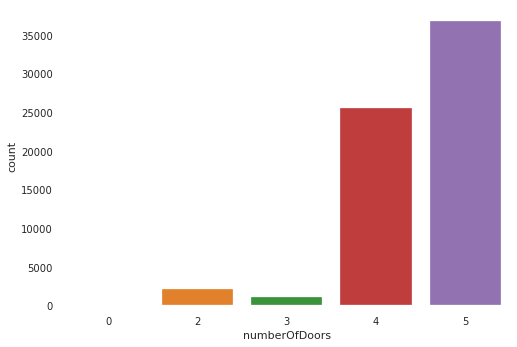

In [74]:
sns.countplot(x = 'numberOfDoors', data = data)

In [75]:
cat_cols.append('numberOfDoors')

**sell_id**

In [76]:
test.sell_id.isna().sum()

0

sell_id - идентификатор объявления,который у нас есть в test-вборке. Пропусков не осталось. Смысловой нагрузки не несет, для обучение не берем.

**vehicleTransmission**

In [77]:
data.vehicleTransmission.value_counts()

автоматическая      37638
механическая        12661
роботизированная     7798
вариатор             7510
Name: vehicleTransmission, dtype: int64

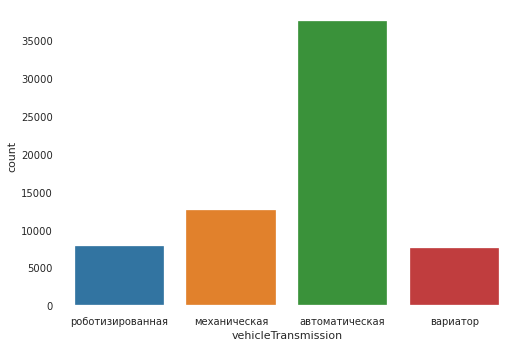

In [78]:
sns.countplot(x = 'vehicleTransmission', data = data)

In [79]:
#определяем в категориальный признак
cat_cols.append('vehicleTransmission')

**Владельцы**

In [80]:
data['Владельцы'].value_counts()

3 или более    27686
1 владелец     11879
2 владельца    10713
1 владелец      8517
2 владельца     6812
Name: Владельцы, dtype: int64

In [81]:
#Очистка
data['Владельцы'] = data['Владельцы'].apply(lambda x: int(x[0])).astype('int32')

In [82]:
data.Владельцы.value_counts()

3    27686
1    20396
2    17525
Name: Владельцы, dtype: int64

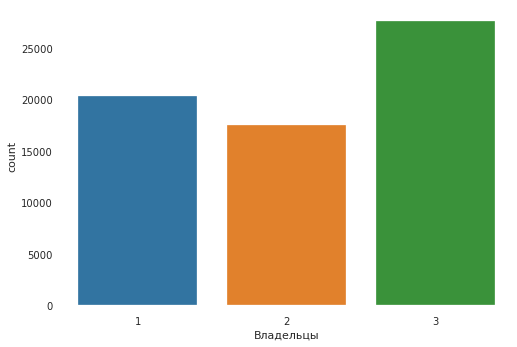

In [83]:
sns.countplot(x = 'Владельцы', data = data)

In [84]:
cat_cols.append('Владельцы')

**ПТС**

In [85]:
data.ПТС.value_counts()

Оригинал    57484
Дубликат     8122
Name: ПТС, dtype: int64

In [86]:
data.ПТС.isna().sum()

1

In [87]:
data.ПТС = data.ПТС.fillna('Оригинал')# заполним пропуск наиболее частым значением

In [88]:
# Преобразуем значения в колонке ПТС
data['ПТС'] = data['ПТС'].apply(lambda x: 1 if x == 'Оригинал' else 0).astype('int8')

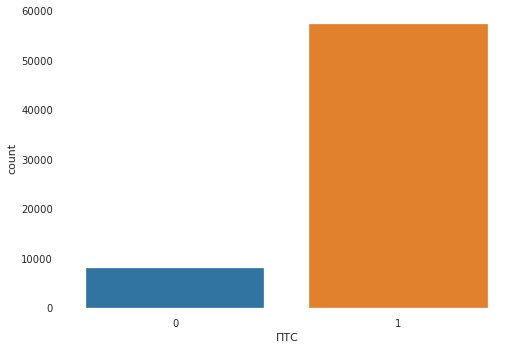

In [89]:
sns.countplot(x = 'ПТС', data = data)

In [90]:
#определяем в бинарные признаки
bin_cols.append('ПТС')

**Привод**

In [91]:
data.Привод.value_counts()

передний    29351
полный      29241
задний       7015
Name: Привод, dtype: int64

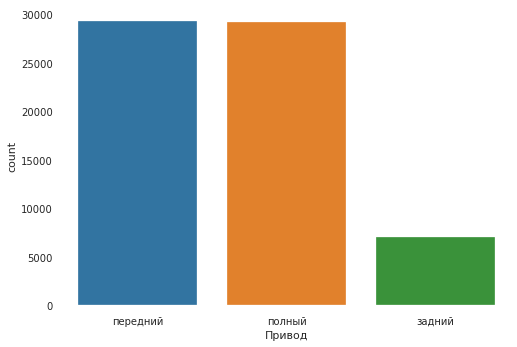

In [92]:
#посмотрим на распределение
sns.countplot(x = 'Привод', data = data)

In [93]:
cat_cols.append('Привод')

**Руль**

In [94]:
data.Руль.value_counts()

Левый     63353
Правый     2254
Name: Руль, dtype: int64

In [95]:
# Преобразуем значения в колонке Руль
data['Руль'] = data['Руль'].apply(lambda x: 1 if x == 'Левый' else 0).astype('int8')

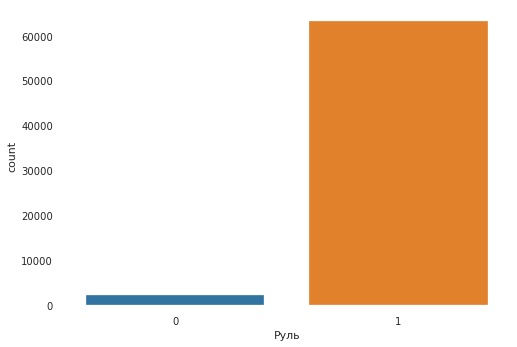

In [96]:
sns.countplot(x = 'Руль', data = data)

In [97]:
bin_cols.append('Руль')

**Состояние**

In [98]:
data.Состояние.unique()

array(['Не требует ремонта', 'Битый / не на ходу'], dtype=object)

In [99]:
# Преобразуем значения в колонке Состояние
data['Состояние'] = data['Состояние'].apply(lambda x: 1 if x == 'Не требует ремонта' else 0).astype('int8')

In [100]:
data.Состояние.value_counts()

1    65605
0        2
Name: Состояние, dtype: int64

In [101]:
bin_cols.append('Состояние')

**Посмотрим на распределение целевой переменной:**

In [102]:
# приведем целевую переменную к числовому типу
data['price'] = data['price'].apply(lambda x: str(x))

In [103]:
data.price = data.price.apply(
    lambda x: ("".join(filter(str.isdigit, x)))).astype('int')

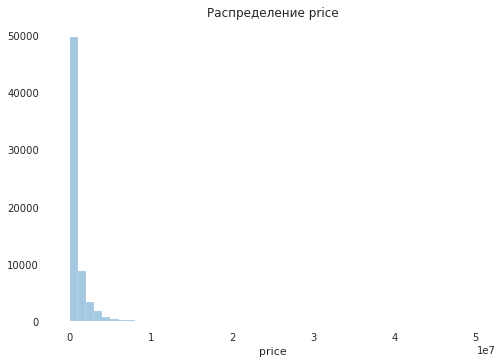

In [104]:
plt.figure()
plt.title(f"Распределение {'price'}")
sns.distplot(data.price, kde=False)

Посмотрим на распределение зависимости цены от марки авто:

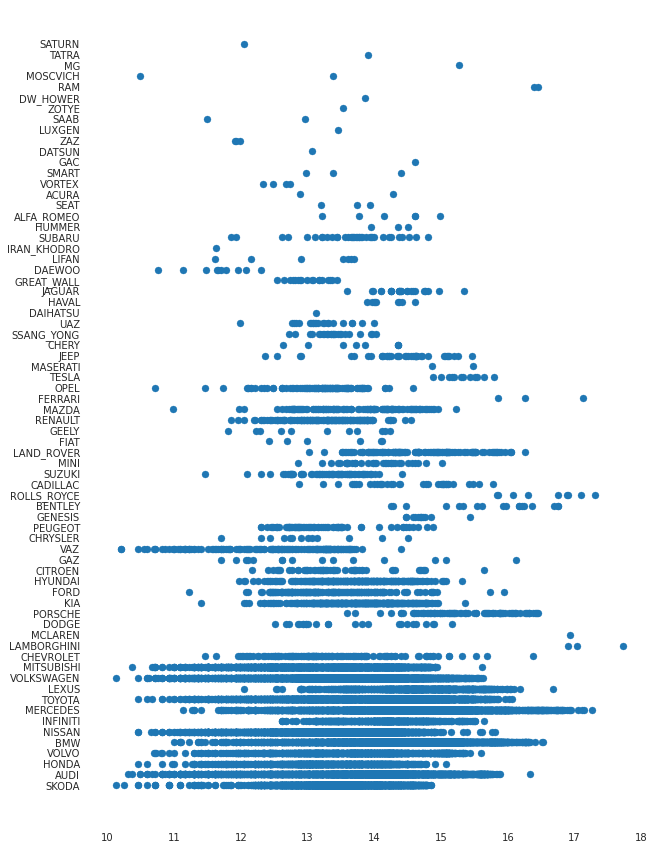

In [105]:
plt.figure(figsize=(10, 15))
plt.scatter(np.log(data.price), data.brand)

Показывает что цены адекватны и зависят от марки авто

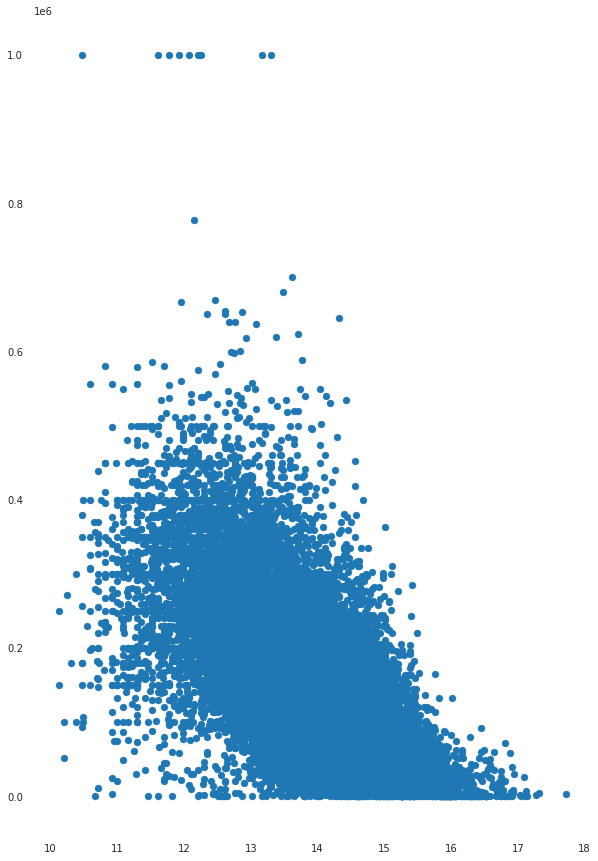

In [106]:
#Посмотрим на распределение зависимости цены от километража
plt.figure(figsize=(10, 15))
plt.scatter(np.log(data.price), data.mileage)

 Удалим признаки, которые на наш взгляд не несут никакой информативности,либо дублируют информацию:

In [107]:
data = data.drop(columns = ['car_url','name','sell_id','parsing_unixtime','vehicleConfiguration','priceCurrency','Таможня'], axis=1)

In [108]:
data.head(5)

,bodyType,brand,color,engineDisplacement,enginePower,fuelType,mileage,modelDate,model_name,numberOfDoors,productionDate,vehicleTransmission,Владельцы,ПТС,Привод,Руль,Состояние,price,sample,description_len,real_photo,mileage_cat,prod_age,model_age
0,лифтбек,SKODA,синий,1,105,бензин,74000,2013,OCTAVIA,5,2014,роботизированная,3,1,передний,1,1,0,0,1001,True,4,7,8
1,лифтбек,SKODA,чёрный,1,110,бензин,60563,2017,OCTAVIA,5,2017,механическая,1,1,передний,1,1,0,0,2609,True,4,4,4
2,лифтбек,SKODA,серый,1,152,бензин,88000,2013,SUPERB,5,2014,роботизированная,1,1,передний,1,1,0,0,1001,True,4,7,8
3,лифтбек,SKODA,коричневый,1,110,бензин,95000,2013,OCTAVIA,5,2014,автоматическая,1,1,передний,1,1,0,0,1676,True,4,7,8
4,лифтбек,SKODA,белый,1,152,бензин,58536,2008,OCTAVIA,5,2012,автоматическая,1,1,передний,1,1,0,0,2365,True,4,9,13


## Label Encoding

In [109]:
for colum in ['bodyType','color','model_name','brand','fuelType', 'vehicleTransmission','Привод','real_photo']:
    data[colum] = data[colum].astype('category').cat.codes

In [110]:
data.sample(5)

,bodyType,brand,color,engineDisplacement,enginePower,fuelType,mileage,modelDate,model_name,numberOfDoors,productionDate,vehicleTransmission,Владельцы,ПТС,Привод,Руль,Состояние,price,sample,description_len,real_photo,mileage_cat,prod_age,model_age
39832,11,62,12,2,79,3,128570,1999,1908,4,2000,0,1,1,1,0,1,240000,1,210,1,4,21,22
68137,11,24,13,2,155,0,197229,2006,51,4,2006,0,3,0,1,1,1,410000,1,487,1,4,15,15
45278,11,45,12,1,117,0,125000,2014,1727,4,2014,1,2,1,1,1,1,690000,1,466,1,4,7,7
58409,0,62,1,2,146,0,9723,2019,1652,5,2019,1,1,1,2,1,1,2119000,1,1098,1,0,2,2
64673,11,2,1,1,190,0,120000,2017,48,4,2017,3,3,1,1,1,1,1495000,1,547,1,4,4,4


In [111]:
print('Категориальныe: {} \nБинарные: {}\nЧисловые: {}'.format(cat_cols, bin_cols,num_cols))

Категориальныe: ['bodyType', 'brand', 'color', 'fuelType', 'engineDisplacement', 'mileage_cat', 'model_name', 'numberOfDoors', 'vehicleTransmission', 'Владельцы', 'Привод'] 
Бинарные: ['real_photo', 'ПТС', 'Руль', 'Состояние']
Числовые: ['description_len', 'enginePower', 'mileage', 'productionDate', 'modelDate', 'prod_age', 'model_age']


# Бинарные признаки

In [112]:
for i in bin_cols:
    display(data[i].value_counts())

1    65044
0      563
Name: real_photo, dtype: int64

1    57485
0     8122
Name: ПТС, dtype: int64

1    63353
0     2254
Name: Руль, dtype: int64

1    65605
0        2
Name: Состояние, dtype: int64

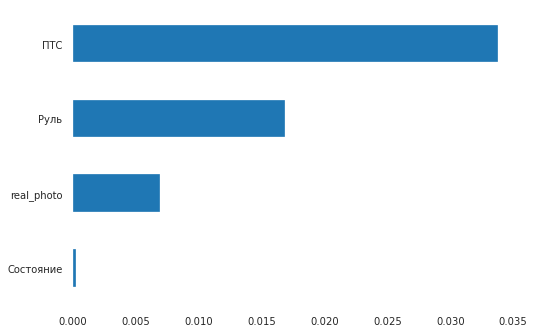

In [113]:
#Проверим значимость бинарных переменных:
df = data[data['sample'] == 0]
imp_cat = Series(mutual_info_classif(data[bin_cols], data['price'],
                                     discrete_features =True), index = bin_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

по графику видим,что сильно больше всего влияют признаки ПТС и Руль на цену

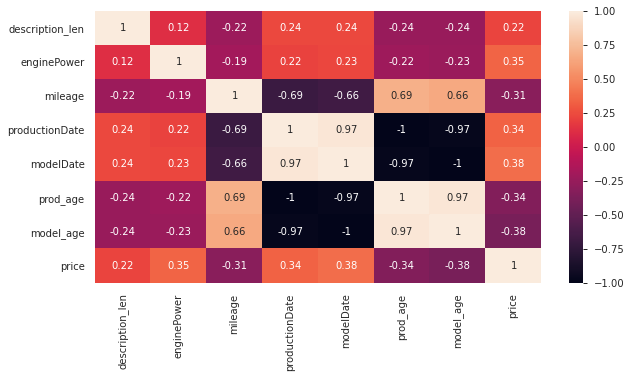

In [114]:
# построим матрицу корреляций для числовых признаков
plt.figure(figsize=(10,5))
sns.heatmap(data[num_cols+['price']].corr(), annot=True)

# Категориальные признаки

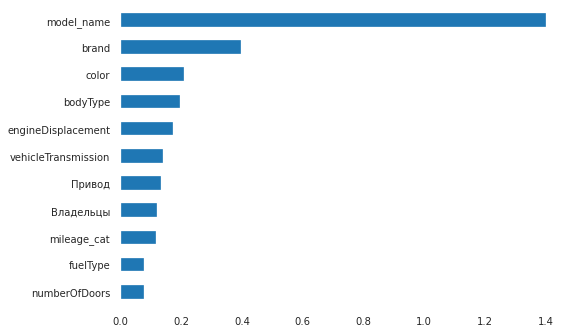

In [115]:
# Проверим значимость категориальных переменных:
temp_df = data[data['sample']==1]
imp_cat = Series(mutual_info_classif(data[cat_cols], data['price'],
                                     discrete_features=True), index=cat_cols)
imp_cat.sort_values(inplace=True)
imp_cat.plot(kind='barh')

Логично,что цена будет зависеть от марки и модели машины

# Числовые признаки

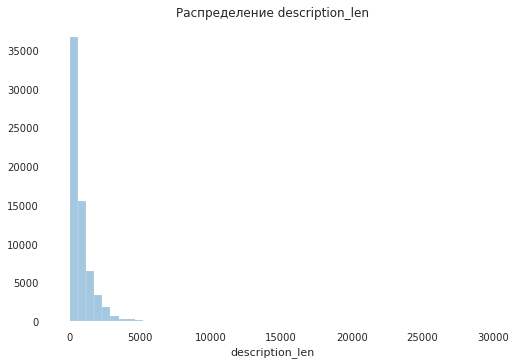

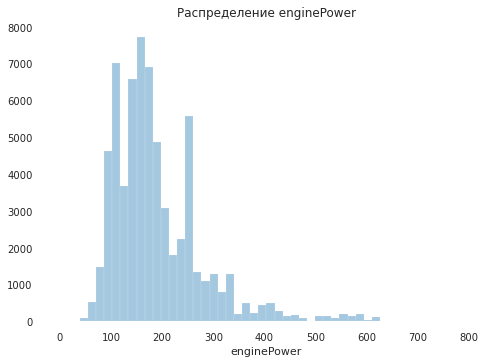

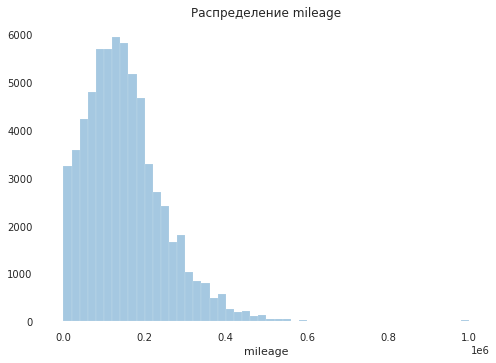

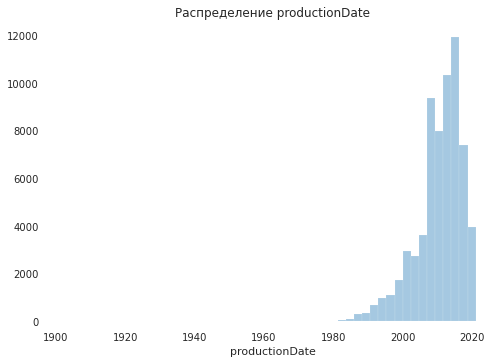

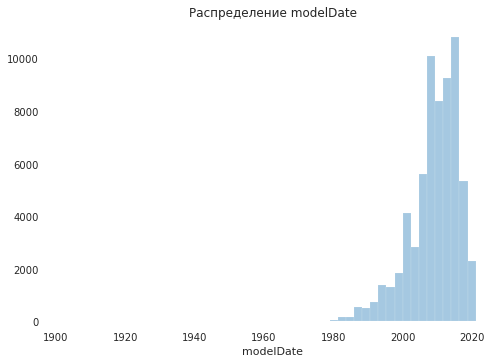

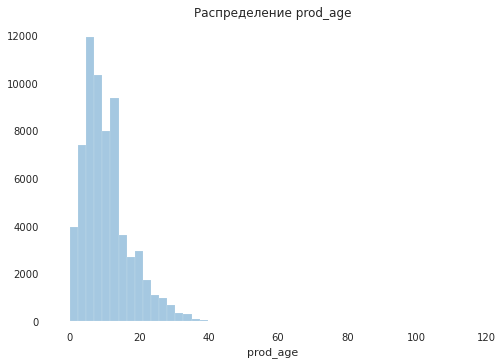

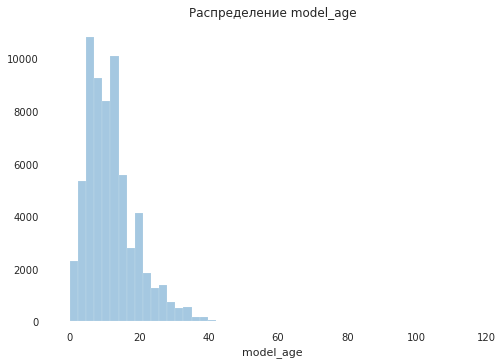

In [116]:
# анализ распределения числовых переменных с помощью визуализации
for col in num_cols:
    plt.figure()
    plt.title(f"Распределение {col}")
    sns.distplot(data[col], kde=False)

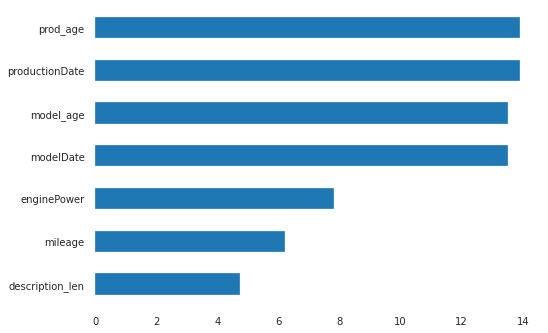

In [117]:
imp_num = Series(f_classif(data[num_cols][data['sample'] == 1], data[data['sample'] == 1]['price'])[0], 
                 index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

Все признаки достаточно сильно влияют на цену

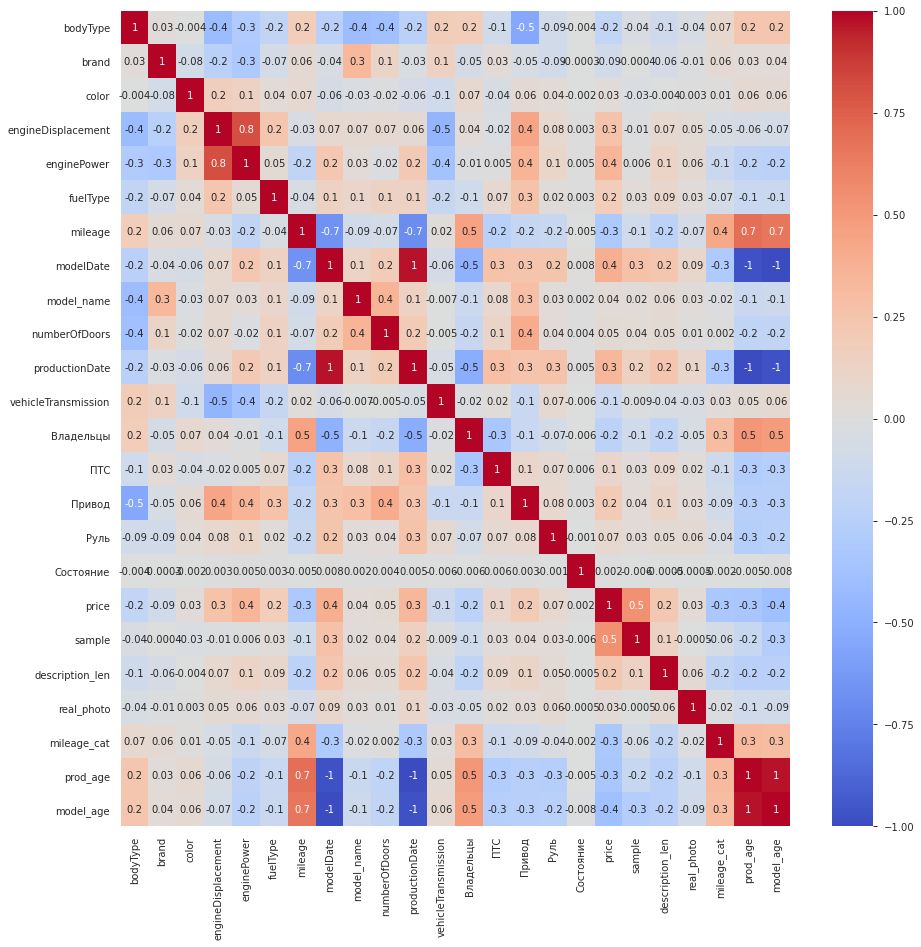

In [118]:
# корреляция

fig, ax = plt.subplots(1, 1, figsize=(15, 15))
ax = sns.heatmap(data.corr(),fmt='.1g',
                 annot=True, cmap='coolwarm')

Видна большая корреляция между признаками 'engineDisplacement' и 'enginePower',а так же искуственно созданными признаками. Удалять не буду, т.к. без них результат становится хуже.

## Train Split

In [119]:
train_data = data.query('sample == 1').drop(['sample'], axis=1)
test_data = data.query('sample == 0').drop(['sample','price'], axis=1)
X = train_data.drop(['price'], axis=1)
y = train_data['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=RANDOM_SEED)

# Model 1: Создадим "наивную" модель 



In [120]:
tmp_train = X_train.copy()
tmp_train['price'] = y_train

In [121]:
# Находим median по экземплярам engineDisplacement в трейне и размечаем тест
predict = X_test['engineDisplacement'].map(tmp_train.groupby('engineDisplacement')['price'].median())
#оцениваем точность
print(f"Точность наивной модели по метрике MAPE: {(mape(y_test, predict.values))*100:0.2f}%")

Точность наивной модели по метрике MAPE: 93.03%


# Простая модель линейной регрессии

In [122]:
from sklearn.linear_model import LinearRegression
linear_regr = LinearRegression().fit(X_train, np.log(y_train+1))
predict_test = np.exp(linear_regr.predict(X_test))
print(f"Точность модели по метрике MAPE: {(mape(y_test, predict_test))*100:0.2f}%")

Точность модели по метрике MAPE: 25.80%


# CatBoost


In [123]:
model = CatBoostRegressor(iterations = 5000,
                          random_seed = RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['R2', 'MAE'],
                          silent=True,
                         )
model.fit(X_train, y_train,
         #cat_features=cat_features_ids,
         eval_set=(X_test, y_test),
         verbose_eval=0,
         use_best_model=True,
         #plot=True
         )

model.save_model('catboost_single_model_baseline.model')

In [124]:
# оцениваем точность
predict = model.predict(X_test)
print(f"Точность модели по метрике MAPE: {(mape(y_test, predict))*100:0.2f}%")

Точность модели по метрике MAPE: 14.81%


### Log Target
Попробуем взять таргет в логорифм - это позволит уменьшить влияние выбросов на обучение модели.    

In [125]:
model = CatBoostRegressor(iterations = 5000,
                          random_seed = RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['R2', 'MAE'],
                          silent=True,
                         )
model.fit(X_train, np.log(y_train),
         #cat_features=cat_features_ids,
         eval_set=(X_test, np.log(y_test)),
         verbose_eval=0,
         use_best_model=True,
         #plot=True
         )

model.save_model('catboost_single_model_2_baseline.model')
predict_test = np.exp(model.predict(X_test))
#predict_submission = np.exp(model.predict(test_data))
print(f"Точность модели по метрике MAPE: {(mape(y_test, predict_test))*100:0.2f}%")

Точность модели по метрике MAPE: 12.51%


# xgboost

In [126]:
# xgboost
import xgboost as xgb
xb = xgb.XGBRegressor(objective='reg:squarederror', colsample_bytree=0.5, learning_rate=0.03, \
                      max_depth=12, alpha=1, n_jobs=-1, n_estimators=1000)
xb.fit(X_train, np.log(y_train+1))
print(f"Точность модели по метрике MAPE: {(mape(y_test, np.exp(xb.predict(X_test))))*100:0.2f}%")
VERSION = 7
predict_test = np.exp(xb.predict(X_test))
predict_submission = np.exp(xb.predict(test_data))

Точность модели по метрике MAPE: 12.13%


# GradientBoosting с подбором параметров

In [127]:
from sklearn.ensemble import GradientBoostingRegressor
def regularise(X_train, y_train):
    max_depth = [5, 10,15]
    n_estimators = [100, 200,1000]
    hyperparameters = dict(max_depth=max_depth, n_estimators=n_estimators)
    model = GradientBoostingRegressor()
    model.fit(X_train, y_train)

    clf = GridSearchCV(model, hyperparameters)

    best_model = clf.fit(X_train, y_train)

    best_max_depth = best_model.best_estimator_.get_params()['max_depth']
    best_n_estimators = best_model.best_estimator_.get_params()['n_estimators']

    return best_max_depth, best_n_estimators

In [128]:
gb = GradientBoostingRegressor(min_samples_split=2, learning_rate=0.03, max_depth=5, n_estimators=1000)
gb.fit(X_train, np.log(y_train+1))
print(f"Точность модели по метрике MAPE: {(mape(y_test, np.exp(gb.predict(X_test))))*100:0.2f}%")

Точность модели по метрике MAPE: 13.69%


# Stacking

In [129]:
scaler = StandardScaler() 
X_train = scaler.fit_transform(X_train) 
X_test = scaler.transform(X_test) 


y_train = y_train 
y_test = y_test

cv = KFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)

def compute_meta_feature(regr, X_train, X_test, y_train, cv):
    X_meta_train = np.zeros_like(y_train, dtype=np.float32)    
    splits = cv.split(X_train)
    for train_fold_index, predict_fold_index in splits:
        X_fold_train, X_fold_predict = X_train[train_fold_index], X_train[predict_fold_index]
        y_fold_train = y_train[train_fold_index]

        folded_regr = clone(regr)
        folded_regr.fit(X_fold_train, y_fold_train)

        X_meta_train[predict_fold_index] = folded_regr.predict(X_fold_predict)

    meta_regr = clone(regr)
    meta_regr.fit(X_train, y_train)

    X_meta_test = meta_regr.predict(X_test)


    return X_meta_train, X_meta_test

def generate_meta_features(regr, X_train, X_test, y_train, cv):
    features = [compute_meta_feature(regr, X_train, X_test, y_train, cv) for regr in tqdm(regr)]    
    stacked_features_train = np.vstack([features_train for features_train, features_test in features]).T
    stacked_features_test = np.vstack([features_test for features_train, features_test in features]).T
    return stacked_features_train, stacked_features_test

X_train = np.where(np.isnan(X_train), 0, X_train)
X_test = np.where(np.isnan(X_test), 0, X_test)
y_train = np.where(np.isnan(y_train), 0, y_train)

In [130]:
regr = RandomForestRegressor(n_estimators=300, min_samples_split=2, min_samples_leaf=1, 
                             max_features=3, max_depth=19, bootstrap=True, random_state=RANDOM_SEED)

stacked_features_train, stacked_features_test = generate_meta_features([
                            regr,
                            GradientBoostingRegressor(min_samples_split=2, learning_rate=0.03, max_depth=10, n_estimators=300),
                            KNeighborsRegressor(n_neighbors=2, algorithm = 'ball_tree', weights = 'distance', p=1),
                            RandomForestRegressor(random_state = RANDOM_SEED, n_jobs = -1, verbose = 1, max_depth=5, n_estimators=200),
                            ExtraTreesRegressor(random_state=RANDOM_SEED), 
                            RandomForestRegressor(random_state=RANDOM_SEED, max_depth=15) \
], X_train, X_test, y_train, cv)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    2.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    2.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 task

In [131]:
def compute_metric(regr, X_train, y_train, X_test, y_test): 
    regr.fit(X_train, y_train) 
    y_test_pred = regr.predict(X_test) 
    return np.round(mape(y_test, y_test_pred)*100, 2)
print(f"Точность модели по метрике MAPE: {compute_metric(regr, stacked_features_train, y_train, stacked_features_test, y_test)}%")

Точность модели по метрике MAPE: 14.54%


# Выводы

* CatBoost и GradientBoosting показывают хороший результат метрики, но лучший результат показал xgboost - 12.13.
* Заметно улучшается результат после логарифмирования целевой переменной


# Submission

In [132]:
sample_submission['price'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,sell_id,price
0,1100575026,6.721525e+05
1,1100549428,1.026830e+06
2,1100658222,9.351362e+05
3,1100937408,8.160542e+05
4,1101037972,7.906956e+05
5,1100912634,7.729230e+05
6,1101228730,6.759278e+05
7,1100165896,4.460376e+05
8,1100768262,2.195120e+06
9,1101218501,8.124658e+05
